In [ ]:
!pip install gpxpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

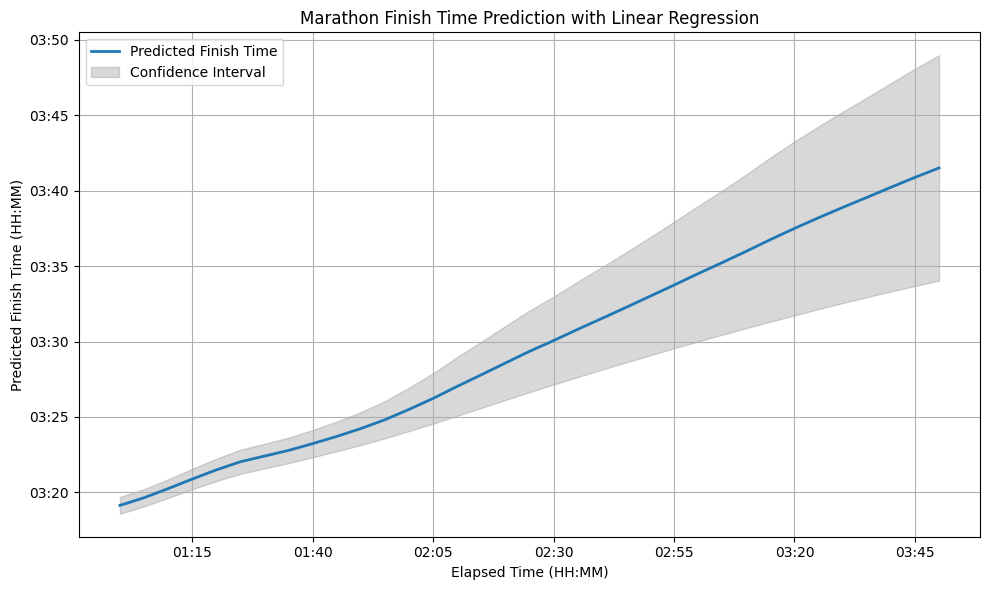

In [20]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import gpxpy
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import matplotlib.ticker as ticker

# --- 1. Read GPX file ---
gpx_file = '/content/Techcombank_Hanoi_Marathon-2.gpx'  # replace with your GPX file path

with open(gpx_file, 'r') as f:
    gpx = gpxpy.parse(f)

points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append({
                'time': point.time,
                'lat': point.latitude,
                'lon': point.longitude,
                'elev': point.elevation
            })

df = pd.DataFrame(points).sort_values('time').reset_index(drop=True)

# --- 2. Compute cumulative distance using geopy ---
distances = [0]
for i in range(1, len(df)):
    prev = (df.loc[i-1, 'lat'], df.loc[i-1, 'lon'])
    curr = (df.loc[i, 'lat'], df.loc[i, 'lon'])
    d = geodesic(prev, curr).meters
    distances.append(d)

df['segment_m'] = distances
df['distance_m'] = df['segment_m'].cumsum()
df['distance_km'] = df['distance_m'] / 1000

# --- 3. Calculate elapsed time ---
df['elapsed_s'] = (df['time'] - df['time'].iloc[0]).dt.total_seconds()
df['elapsed_min'] = df['elapsed_s'] / 60

# --- 4. Predict finish time using linear regression every 5 minutes (start after 1h) ---
MARATHON_DISTANCE_KM = 42.195
checkpoints = np.arange(3600, df['elapsed_s'].iloc[-1], 300)  # start after 1h, every 5 min
predictions = []

for t in checkpoints:
    recent = df[df['elapsed_s'] <= t]
    if len(recent) < 10:
        continue

    X = recent[['distance_km']]
    y = recent['elapsed_min']

    model = LinearRegression().fit(X, y)

    # Predict time when distance = 42.195 km (keep column name to avoid warning)
    pred_input = pd.DataFrame({'distance_km': [MARATHON_DISTANCE_KM]})
    predicted_finish_min = model.predict(pred_input)[0]

    # Confidence-like interval from residuals
    residuals = y - model.predict(X)
    std_resid = np.std(residuals)
    conf_low = predicted_finish_min - 1.96 * std_resid
    conf_high = predicted_finish_min + 1.96 * std_resid

    predictions.append({
        'elapsed_min': t / 60,
        'predicted_finish_min': predicted_finish_min,
        'conf_low': conf_low,
        'conf_high': conf_high
    })

pred_df = pd.DataFrame(predictions)

# --- 5. Helper: convert minutes to HH:MM format ---
def min_to_hhmm(x):
    td = timedelta(minutes=x)
    h, m = divmod(td.seconds // 60, 60)
    return f"{td.days*24 + h:02d}:{m:02d}"

# --- 6. Plot ---
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pred_df['elapsed_min'], pred_df['predicted_finish_min'], label='Predicted Finish Time', linewidth=2)
ax.fill_between(pred_df['elapsed_min'], pred_df['conf_low'], pred_df['conf_high'],
                color='gray', alpha=0.3, label='Confidence Interval')

# Axis formatting: convert minutes → HH:MM
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: min_to_hhmm(x)))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: min_to_hhmm(y)))

plt.xlabel('Elapsed Time (HH:MM)')
plt.ylabel('Predicted Finish Time (HH:MM)')
plt.title('Marathon Finish Time Prediction with Linear Regression')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

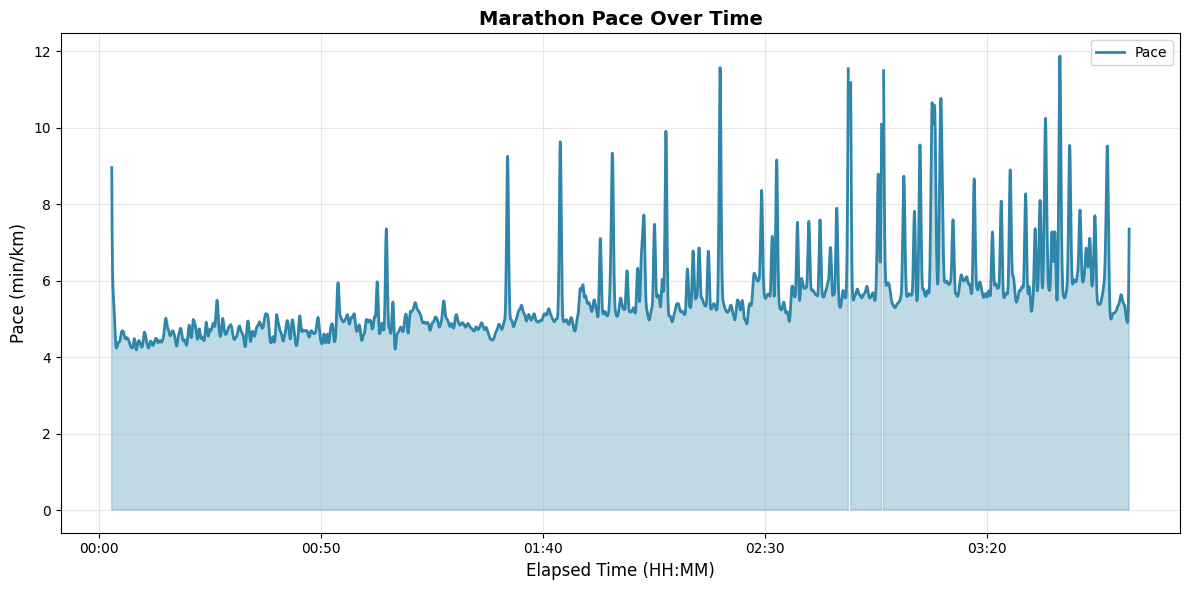


Pace Statistics:
Average Pace: 5.55 min/km
Median Pace: 5.25 min/km
Fastest Pace: 4.14 min/km
Slowest Pace: 14.95 min/km


In [22]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
import gpxpy
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import matplotlib.ticker as ticker

# --- 1. Read GPX file ---
gpx_file = '/content/Techcombank_Hanoi_Marathon-2.gpx' # replace with your GPX file path
with open(gpx_file, 'r') as f:
    gpx = gpxpy.parse(f)

points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append({
                'time': point.time,
                'lat': point.latitude,
                'lon': point.longitude,
                'elev': point.elevation
            })

df = pd.DataFrame(points).sort_values('time').reset_index(drop=True)

# --- 2. Compute cumulative distance using geopy ---
distances = [0]
for i in range(1, len(df)):
    prev = (df.loc[i-1, 'lat'], df.loc[i-1, 'lon'])
    curr = (df.loc[i, 'lat'], df.loc[i, 'lon'])
    d = geodesic(prev, curr).meters
    distances.append(d)

df['segment_m'] = distances
df['distance_m'] = df['segment_m'].cumsum()
df['distance_km'] = df['distance_m'] / 1000

# --- 3. Calculate elapsed time ---
df['elapsed_s'] = (df['time'] - df['time'].iloc[0]).dt.total_seconds()
df['elapsed_min'] = df['elapsed_s'] / 60

# --- 7. Calculate pace using rolling window (FIXED) ---
# Use a window of points to calculate pace over a reasonable distance
window_size = 30  # Number of points to average over

# Calculate pace using rolling windows
df['pace_min_per_km'] = np.nan

for i in range(window_size, len(df)):
    # Look back over the last 'window_size' points
    time_diff = df.loc[i, 'elapsed_s'] - df.loc[i - window_size, 'elapsed_s']
    dist_diff = df.loc[i, 'distance_m'] - df.loc[i - window_size, 'distance_m']

    if dist_diff > 0:  # Avoid division by zero
        pace = (time_diff / 60) / (dist_diff / 1000)  # min/km
        df.loc[i, 'pace_min_per_km'] = pace

# Remove outliers (pace < 2 min/km or > 15 min/km are likely GPS errors)
df['pace_min_per_km'] = df['pace_min_per_km'].apply(lambda x: x if 2 <= x <= 15 else np.nan)

# Additional smoothing for visualization
df['smoothed_pace_min_per_km'] = df['pace_min_per_km'].rolling(window=20, center=True).mean()

# Helper function for time formatting
def min_to_hhmm(x, _=None):
    hours = int(x // 60)
    mins = int(x % 60)
    return f'{hours:02d}:{mins:02d}'

# --- 8. Plot pace over time ---
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['elapsed_min'], df['smoothed_pace_min_per_km'], label='Pace', linewidth=2, color='#2E86AB')
ax.fill_between(df['elapsed_min'], df['smoothed_pace_min_per_km'], alpha=0.3, color='#2E86AB')

# Axis formatting
ax.xaxis.set_major_formatter(ticker.FuncFormatter(min_to_hhmm))
plt.xlabel('Elapsed Time (HH:MM)', fontsize=12)
plt.ylabel('Pace (min/km)', fontsize=12)
plt.title('Marathon Pace Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nPace Statistics:")
print(f"Average Pace: {df['pace_min_per_km'].mean():.2f} min/km")
print(f"Median Pace: {df['pace_min_per_km'].median():.2f} min/km")
print(f"Fastest Pace: {df['pace_min_per_km'].min():.2f} min/km")
print(f"Slowest Pace: {df['pace_min_per_km'].max():.2f} min/km")